# Проект: классификация

Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная deposit - согласится ли клиент открыть депозит в банке. 

In [307]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

### Знакомство с данными, обработка пропусков и выбросов

In [106]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Имеем 6 целочисленных признаков, 10 категориальных и одну категориальную целевую переменную deposit.

25 пропущенных значений есть в колонке balance.

Проанализируем признаки детальнее

In [4]:
df.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [5]:
df.describe(include=['object'])

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


Признаки **default, housing, loan, deposit** - бинарные. Преобразуем их позднее.

Признак **balance** - числовой. Преобразуем его позднее.

Признак **month** позднее преобразуем к дате вместе с признаком day, чтобы получить дату последнего контакта.

**job**

In [6]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Не у всех клиентов заполнены сферы деятельности, у 70 указано значение unknown

**marital**

In [7]:
df.marital.value_counts()

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

**education**

In [8]:
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

Образование также заполнено не везде, у 497 клиентов неизвестен уровень образования

**contact**

In [9]:
df.contact.value_counts()

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

Тип контакта с клиентом не указан для 21% записей

**poutcome**

In [10]:
df.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

Также нет данных для большинства клиентов о результатах прошлой маркетинговой компании

In [117]:
df['balance'] = df['balance'].apply(lambda x: x if pd.isna(x) else float(x.replace(' $', '').replace(',', '.').replace(' ', '')))
df['balance'] = df['balance'].fillna(df['balance'].median())

df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]

df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

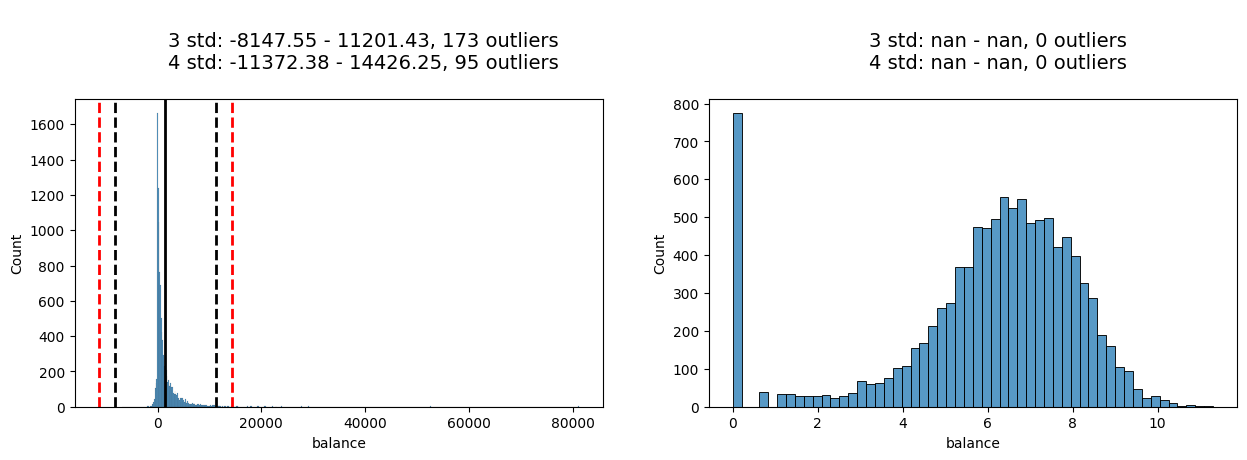

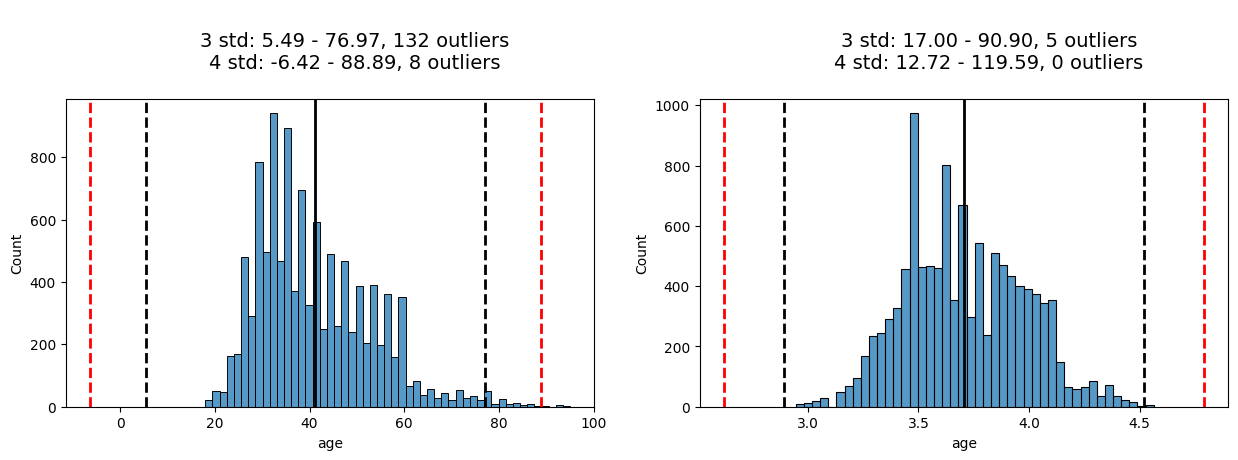

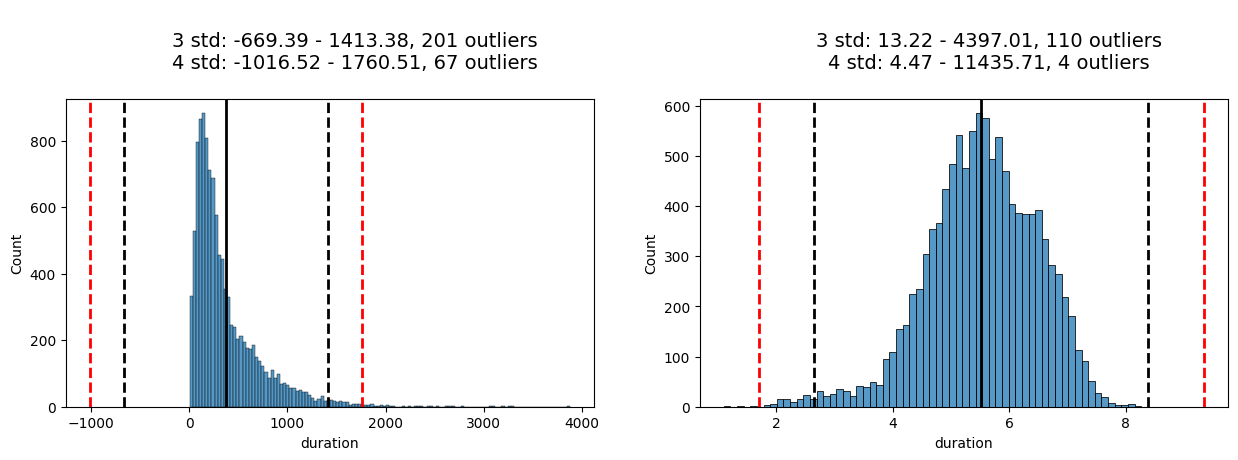

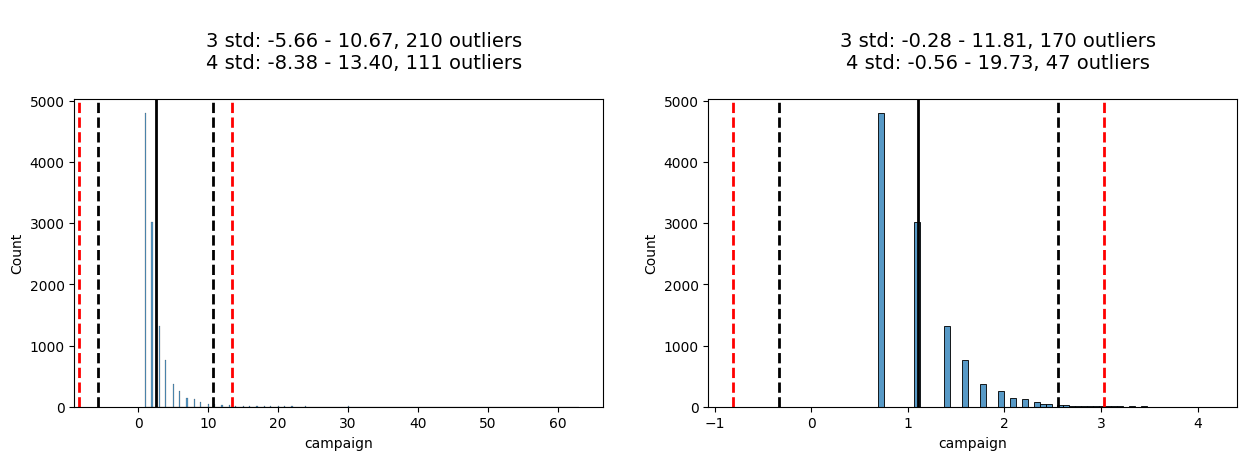

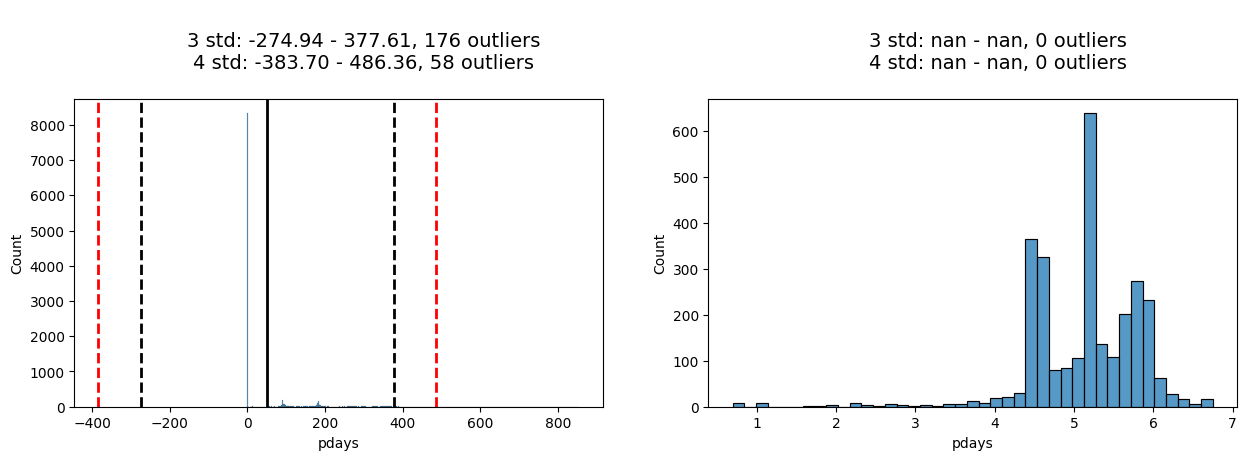

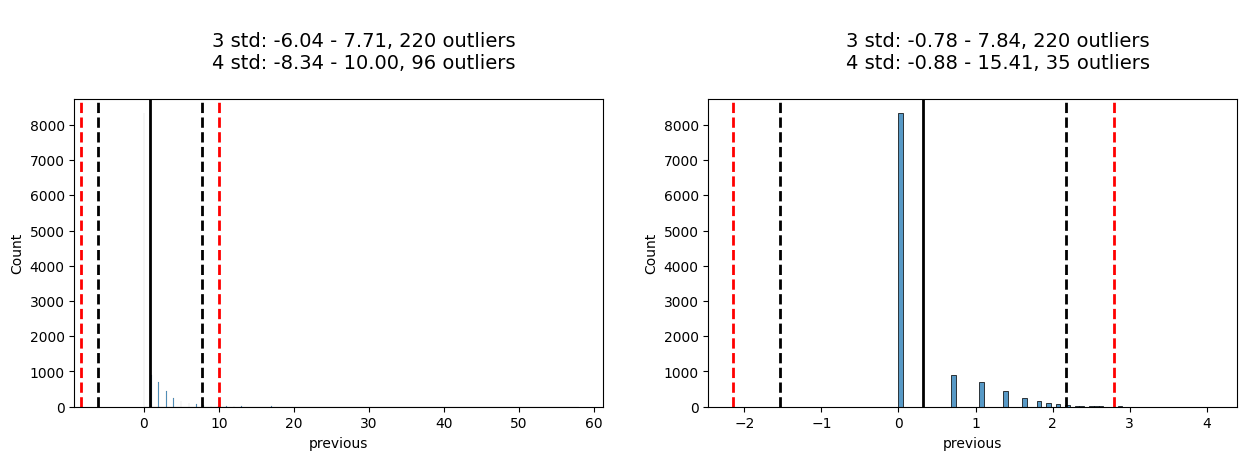

In [119]:
def histogram(feature, log_scale=False):
    #Строим гистограмму
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    test_data =df 
    
    hist1 = sns.histplot(data=test_data, x=feature, ax=axes[0]);
    feature_data = df[feature]
    #Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
    feature_mean = feature_data.mean()
    feature_std = feature_data.std()
    lower_bound = feature_mean - 3*feature_data.std()
    upper_bound = feature_mean + 3*feature_data.std()
    lower_bound_2 = feature_mean - 4*feature_data.std()
    upper_bound_2 = feature_mean + 4*feature_data.std()
    axes[0].axvline(feature_mean, color='k', lw=2)
    axes[0].axvline(upper_bound, color='k', ls='--', lw=2)
    axes[0].axvline(lower_bound, color='k', ls='--', lw=2);
    axes[0].axvline(upper_bound_2, color='r', ls='--', lw=2)
    axes[0].axvline(lower_bound_2, color='r', ls='--', lw=2);
    
    rows_cnt = test_data[(test_data[feature] < lower_bound) | (test_data[feature] > upper_bound)].shape[0]
    rows_cnt_2 = test_data[(test_data[feature] < lower_bound_2) | (test_data[feature] > upper_bound_2)].shape[0]
    hist1.set_title(f"""
        3 std: {lower_bound:0.2f} - {upper_bound:0.2f}, {rows_cnt} outliers
        4 std: {lower_bound_2:0.2f} - {upper_bound_2:0.2f}, {rows_cnt_2} outliers
    """, fontsize=14)
    
    
    #Логарифмируем
    log_feature = np.log(test_data[feature]+1)
    #Строим гистограмму в логарифмическом масштабе
    hist2 = sns.histplot(data=log_feature, ax=axes[1]);
    #Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
    log_mean = log_feature.mean()
    log_std = log_feature.std()
    log_lower_bound = log_mean - 3*log_std
    log_upper_bound = log_mean + 3*log_std
    log_lower_bound_2 = log_mean - 4*log_std
    log_upper_bound_2 = log_mean + 4*log_std
    axes[1].axvline(log_mean, color='k', lw=2)
    axes[1].axvline(log_lower_bound, color='k', ls='--', lw=2)
    axes[1].axvline(log_upper_bound, color='k', ls='--', lw=2);
    axes[1].axvline(log_lower_bound_2, color='r', ls='--', lw=2)
    axes[1].axvline(log_upper_bound_2, color='r', ls='--', lw=2);
    
    log_rows_cnt = test_data[(test_data[feature] < (np.exp(log_lower_bound)-1)) | (test_data[feature] > (np.exp(log_upper_bound)-1))].shape[0]
    log_rows_cnt_2 = test_data[(test_data[feature] < (np.exp(log_lower_bound_2)-1)) | (test_data[feature] > (np.exp(log_upper_bound_2)-1))].shape[0]
    hist2.set_title(f"""
        3 std: {np.exp(log_lower_bound)-1:0.2f} - {np.exp(log_upper_bound)-1:0.2f}, {log_rows_cnt} outliers
        4 std: {np.exp(log_lower_bound_2)-1:0.2f} - {np.exp(log_upper_bound_2)-1:0.2f}, {log_rows_cnt_2} outliers
    """, fontsize=14)
    

outliers_features = ['balance', 'age', 'duration', 'campaign', 'pdays', 'previous']

for outliers_feature in outliers_features:
    histogram(outliers_feature, log_scale=False)

In [123]:
# напишем функцию для поиска выбросов
def outliers_iqr(data, feature, log_scale=False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    Q_25 = x.quantile(0.25)
    Q_75 = x.quantile(0.75)
    IQR = Q_75 - Q_25
    lower_bound = Q_25 - left * IQR
    upper_bound = Q_75 + right * IQR
    outlires = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outlires, cleaned

In [124]:
# применим функцию к балансу
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [125]:
df = cleaned

## Разведывательный анализ

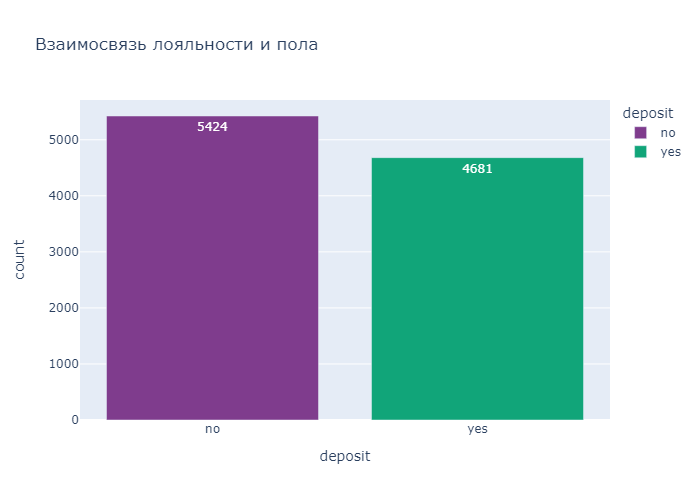

In [144]:
df_deposit = df.groupby('deposit', as_index=False).balance.count()
df_deposit.rename(columns = {'balance': 'count'}, inplace=True)


fig = px.bar(
    data_frame=df_deposit,
    x='deposit',
    y='count',
    title='Взаимосвязь лояльности и пола',
    text='count',
    color='deposit',
    height=500,
    width=700,
    color_discrete_sequence=px.colors.qualitative.Bold,
)
fig.show("png")

В данных клиентов, открывших депозит меньше, чем отказавшихся. Однако дисбаланс не очень большой.

In [165]:
def get_percent_bar(column_name, deposit_ascending=True):
    df_grouped = df.groupby([column_name, 'deposit'], as_index=False).balance.count().sort_values('deposit', ascending=deposit_ascending)
    df_grouped.rename(columns = {'balance':'dep_count'}, inplace = True)
    df_common = df_grouped.groupby(column_name, as_index=False).dep_count.sum()
    df_common.rename(columns = {'dep_count':'common_count'}, inplace = True)
    df_grouped = df_grouped.merge(df_common, on=[column_name])
    df_grouped['percent'] = round(df_grouped['dep_count']*100/df_grouped['common_count'], 2)

    fig = px.bar(
        data_frame=df_grouped,
        x=column_name,
        y='dep_count',
        title=f'Взаимосвязь открытия депозита и признака {column_name}',
        color='deposit',
        text = 'percent',
        height=700,
        width=700,
        color_discrete_sequence=px.colors.qualitative.Bold,
    )
    fig.show("png")

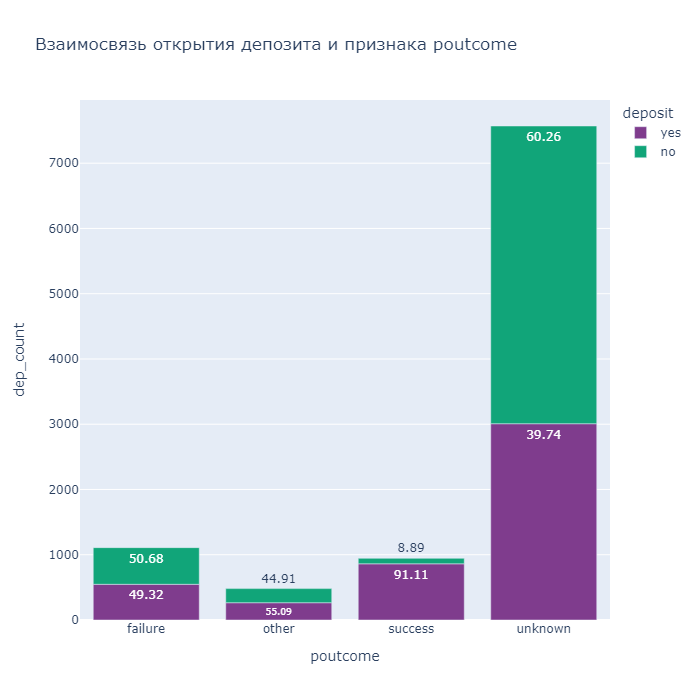

In [167]:
get_percent_bar('poutcome', deposit_ascending=False)

По графику видно, что среди клиентов, открывавших депозит ранее, отказов гораздо меньше.

Интересно, к какой категории отнесены клиенты, которым не предлагалось участвовать ранее. Неизвестно, находятся ли они в составе категории unknown или other.

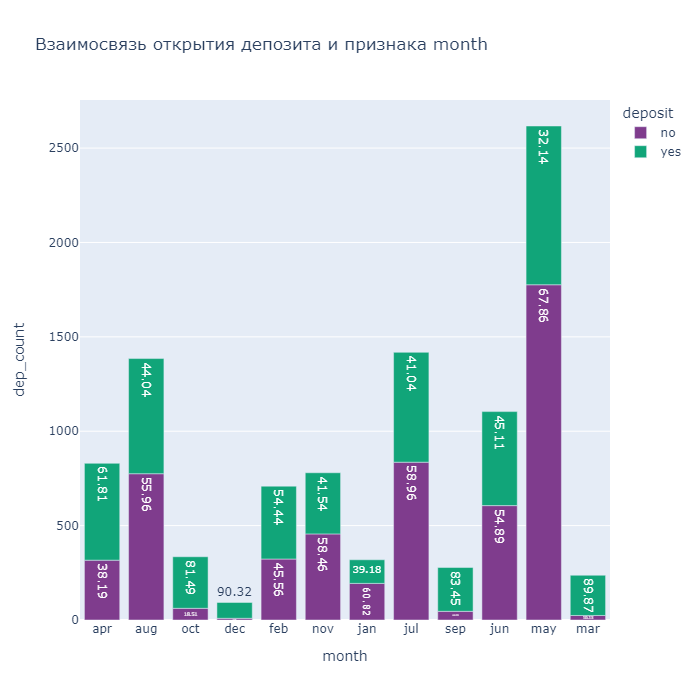

In [168]:
get_percent_bar('month')

В мае наблюдается наибольшее количество маркетинговых предложений, а также наибольший процент отказов.

Возможно, в этом месяце не стоит проводить маркетинговые акции. А, возможно, менеджеры просто активизировались в мае и обзванивали все контакты без исключения, даже холодных клиентов.

In [158]:
def get_age_group(age):
    group = ''
    if age < 30:
        group = '30-'
    elif age < 40:
        group = '30-40'
    elif age < 50:
        group = '40-50'
    elif age < 60:
        group = '50-60'
    else:
        group = '60+'
    return group
    
df['age_group'] = df.age.apply(get_age_group)

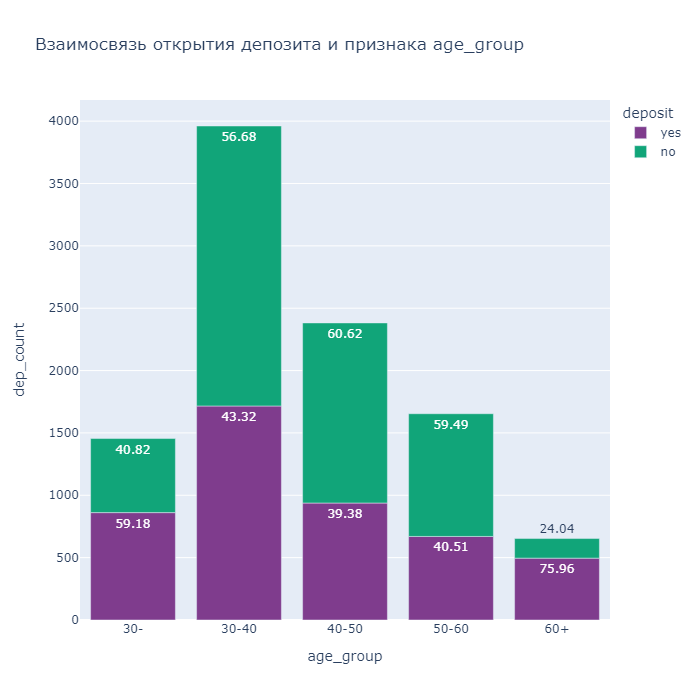

In [169]:
get_percent_bar('age_group', deposit_ascending=False)

Чаще депозиты открывают либо молодые клиенты (<30 лет), либо пожилые (> 60 лет)

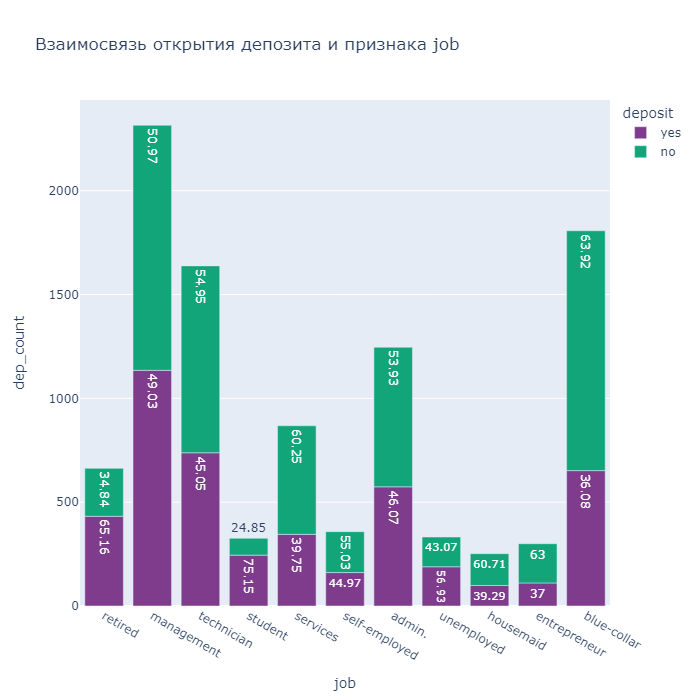

In [164]:
get_percent_bar('job', deposit_ascending=False)

Среди клиентов банка чаще всего встречаются управленцы, офисные работники, а также технические специальности.

В процентном соотношении чаще всего открывают депозит студенты и уволенные. Это удивительно, т.к. предполагается, что это самые материально необеспеченные категории. Возможно, при увольнении сотрудники получают выплаты за несколько месяцев, которые они могут положить на депозит.

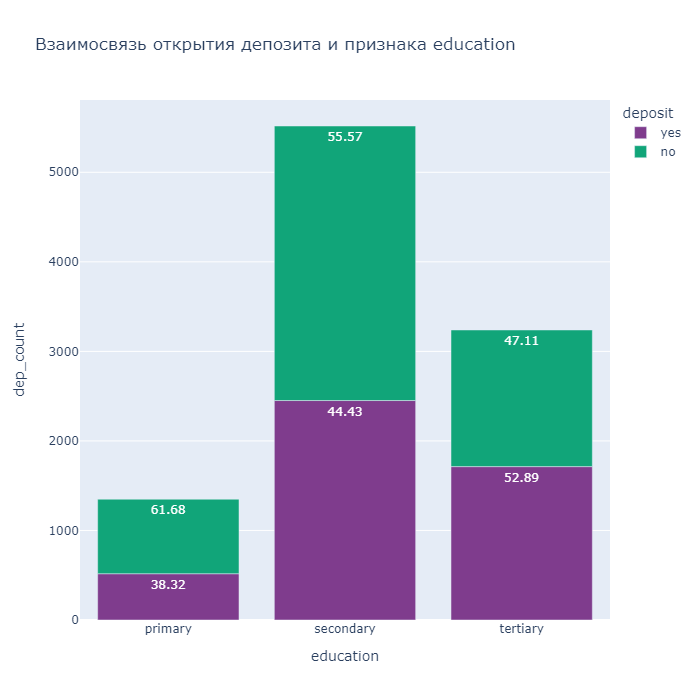

In [170]:
get_percent_bar('education', deposit_ascending=False)

Люди, получившие только начальное образование, гораздо реже являются клиентами банка. 

Чем выше уровень образования, тем чаще в процентном соотношении клиенты банка открываютдепозиты. Вероятно, это связано с тем, что отсутствие нужного образования не позволяет занимать определенные должносии и получать доход, который позволяет откладывать деньги.

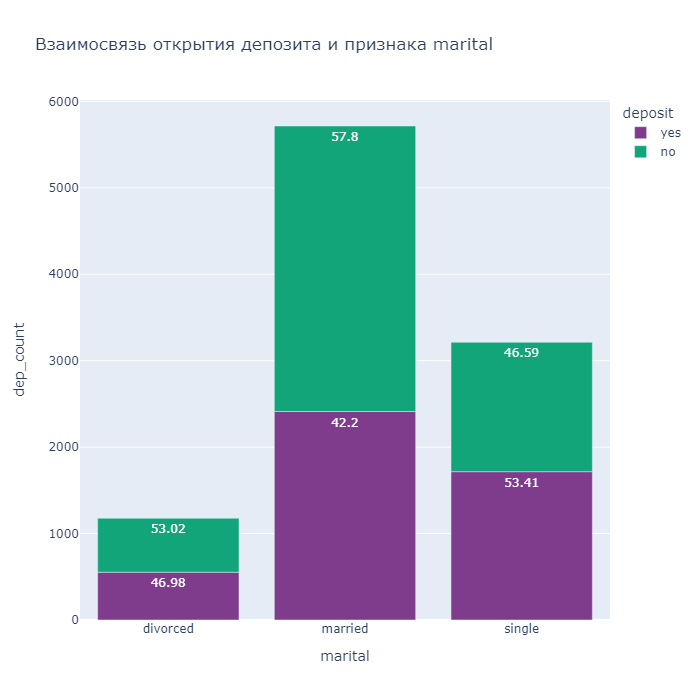

In [171]:
get_percent_bar('marital', deposit_ascending=False)

В большинстве своем клиенты банка женаты/замужем. Однако процент открывших депозит среди состоящих в браке ниже, чем среди одиноких/разведенных. Возможно, это связано с тем, что в полных семьях чаще есть дети, и расходы на них не позволяют откладывать деньги и открывать депозиты. 

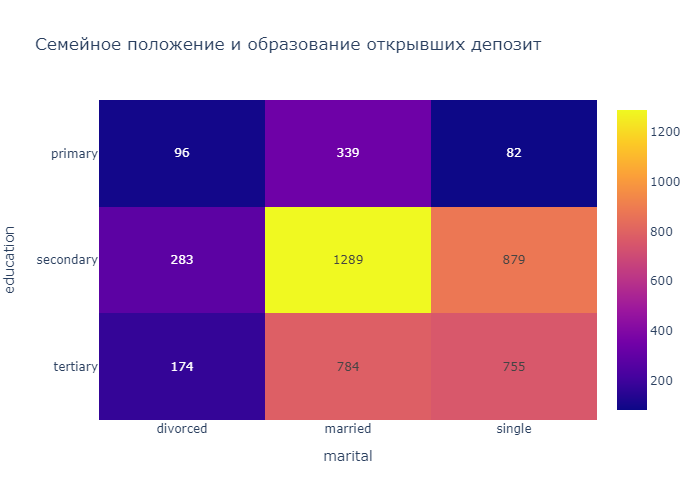

In [177]:
pivot = df[df['deposit'] == 'yes'].pivot_table(
    values='balance',
    index='education',
    columns='marital',
    aggfunc='count',
    fill_value=0
)

fig = px.imshow(
    pivot,
    text_auto=True,
    aspect="auto",
    title='Семейное положение и образование открывших депозит'
)
fig.show("png")

Больше всего открытых депозитов принадлежит людям со средним образованием, состоящим в браке

### Преобразование данных

In [179]:
label_encoder = preprocessing.LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df['age_group'] = label_encoder.fit_transform(df['age_group'])

df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

columns = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=columns, prefix=columns);

<AxesSubplot: >

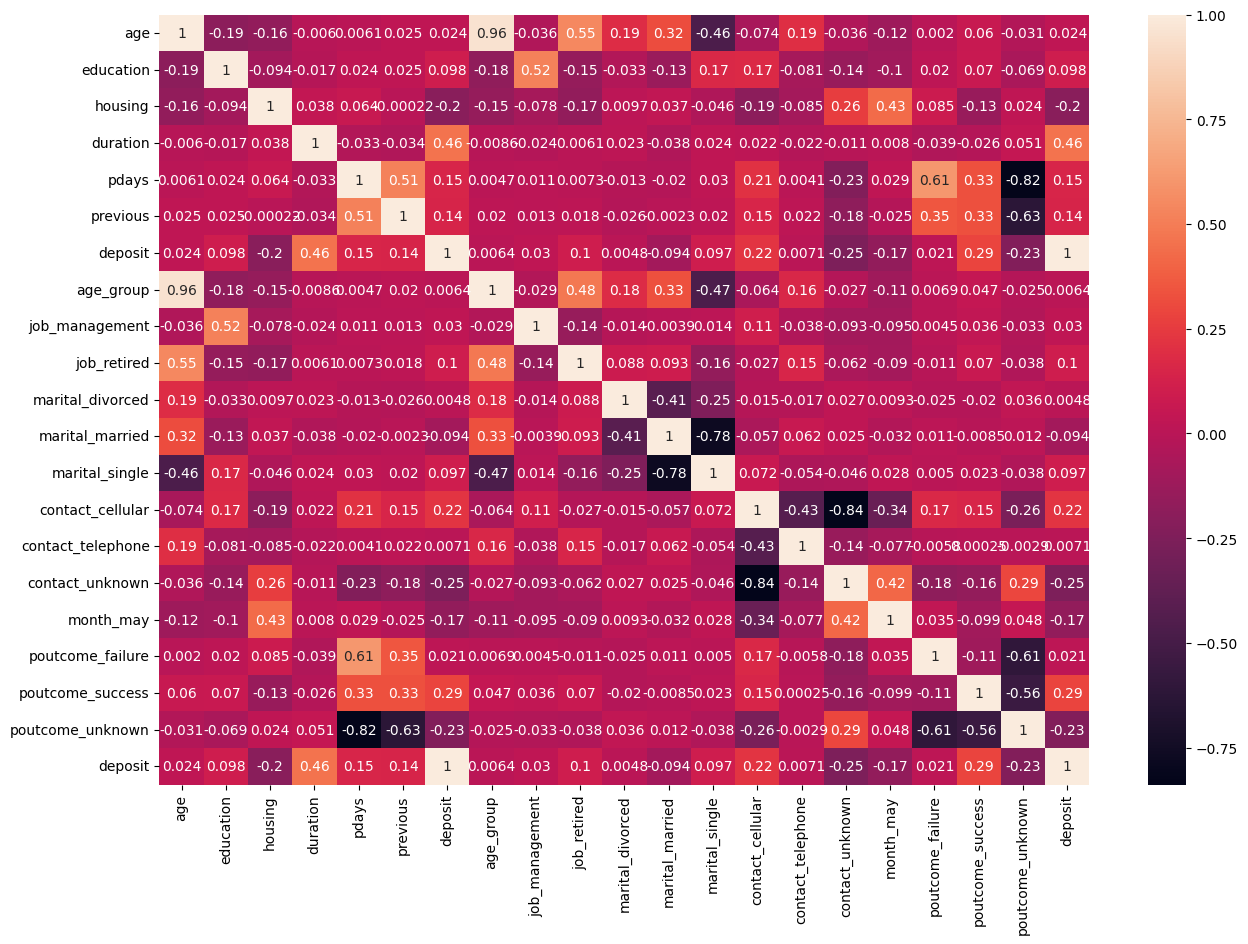

In [209]:
df_corr = df.corr()
result_columns = []
for column in df_corr:
    col_data = df_corr[column]
    if col_data.min() < -0.4 or col_data.sort_values(ascending=False)[1] > 0.4:
        result_columns.append(column)
result_columns.append('deposit')
        
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[result_columns].corr(), annot=True)

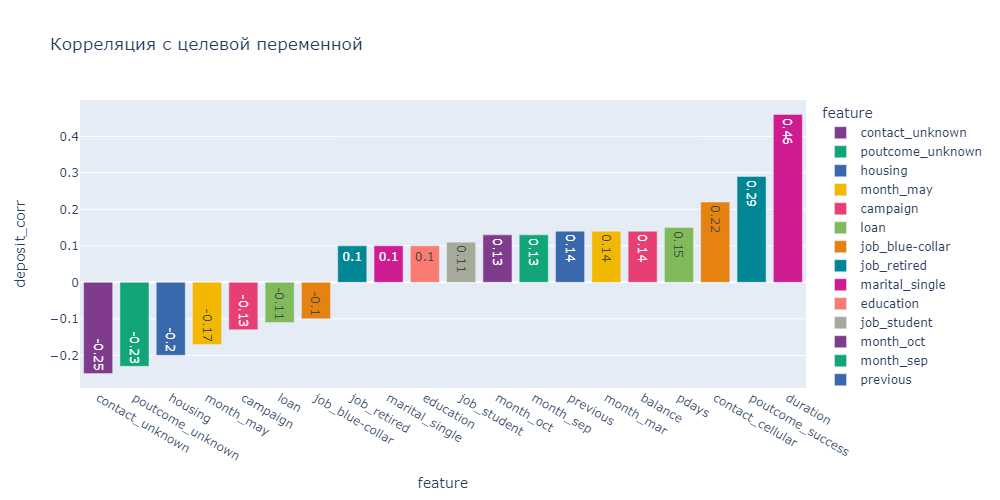

In [257]:
correlations = round(df.corr()['deposit'].drop('deposit'), 2)
correlations = correlations.reset_index().sort_values(by='deposit')
correlations.rename(columns={'index': 'feature', 'deposit': 'deposit_corr'}, inplace=True)
correlations = correlations[(correlations['deposit_corr'] >0.09) | (correlations['deposit_corr'] <-0.09)]

fig = px.bar(
    data_frame=correlations,
    x='feature',
    y='deposit_corr',
    title='Корреляция с целевой переменной',
    text='deposit_corr',
    color='feature',
    height=500,
    width=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
)
fig.show("png")

Максимальная сила взаимосвязи признаков - 0.84. Будем считать, что удалть признаки необходимо при силе взаимосвязи не менее 0.9.

Наиболее коррелирующий с целефой переменной признак - duration

In [210]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [216]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()
columns

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [270]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
X_train_mm = mm_scaler.fit_transform(X_train[columns])
X_test_mm = mm_scaler.transform(X_test[columns])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train = pd.DataFrame(X_train_mm, columns=columns)
X_test = pd.DataFrame(X_test_mm, columns=columns)

## Решение задачи классификации: логистическая регрессия и решающие деревья

In [271]:
random_state = 42

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=random_state, max_iter=1000, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



In [272]:

print('accuracy_score на тестовом наборе: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


accuracy_score на тестовом наборе: 0.8042


In [278]:
#Создаем объект класса случайный лес
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

#Обучаем модель
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


print('accuracy_score на тестовом наборе: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

accuracy_score на тестовом наборе: 0.7535


In [286]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(
    estimator= tree.DecisionTreeClassifier(
        random_state=random_state, #генератор случайных чисел
        criterion='entropy',
    ), 
    param_grid=param_grid, 
    scoring='f1',
    # cv=10, 
    # n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
print("f1_score на тестовом наборе: {:.3f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.784
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


## Решение задачи классификации: ансамбли моделей и построение прогноза

In [291]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10
)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [292]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

#Обучаем модель
gb.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


print('accuracy_score на тестовом наборе: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

accuracy_score на тестовом наборе: 0.8240
f1_score на тестовом наборе: 0.8143


In [294]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train, y_train)
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3634
           1       0.84      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

precision_score на тестовом наборе: 0.8104


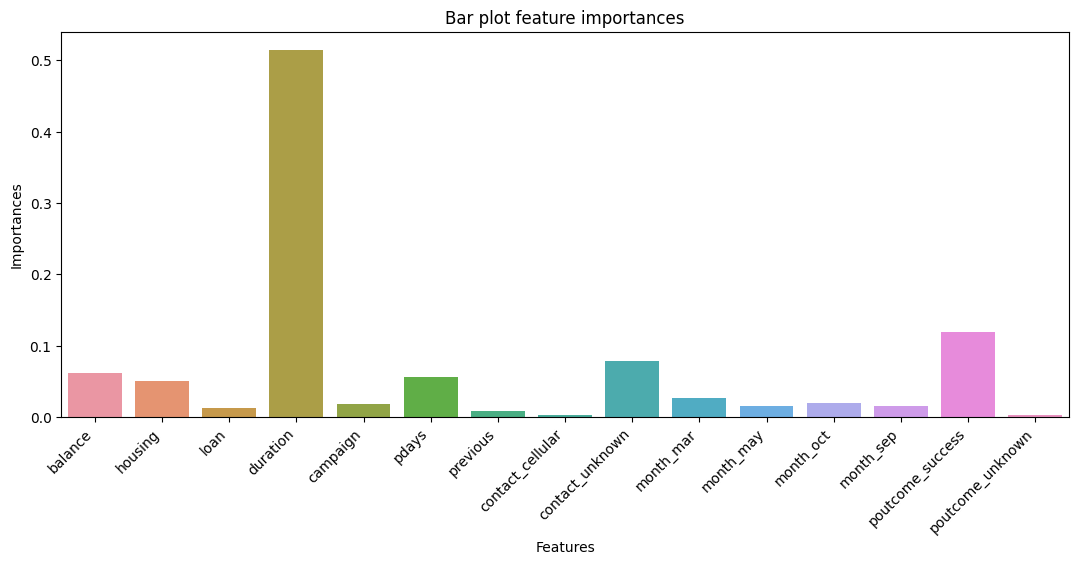

In [300]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

In [308]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  # score = metrics.f1_score(y_train, model.predict(X_train))
  score = cross_val_score(model, X_train, y_train, cv=10, scoring="f1", n_jobs=-1).mean()

  return score

In [309]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-03 16:08:44,553] A new study created in memory with name: RandomForestClassifier
[I 2023-05-03 16:09:02,644] Trial 0 finished with value: 0.8180721090184708 and parameters: {'n_estimators': 195, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8180721090184708.
[I 2023-05-03 16:09:07,628] Trial 1 finished with value: 0.8154209727567892 and parameters: {'n_estimators': 103, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8180721090184708.
[I 2023-05-03 16:09:14,242] Trial 2 finished with value: 0.8180344374389186 and parameters: {'n_estimators': 144, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8180721090184708.
[I 2023-05-03 16:09:23,432] Trial 3 finished with value: 0.8160411433823315 and parameters: {'n_estimators': 177, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8180721090184708.
[I 2023-05-03 16:09:31,016] Trial 4 finished with value: 0.8192986387479216 and parameters: {'n_

CPU times: total: 30.3 s
Wall time: 2min 46s


In [311]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81
accuracy_score на тестовом наборе: 0.82
